# RNN text sentiment analyzer

In [1]:
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import torch.nn as nn
import tqdm
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

from utils.text_datasets import get_poem_sentiment_dataset
from utils.metrics import display_clasification_metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

# Data

In [3]:
BATCH_SIZE = 128

In [4]:
corpus = api.load("text8")
gensim_model = Word2Vec(corpus)
tokenizer = gensim_model.wv.key_to_index
emb_weights = torch.FloatTensor(gensim_model.wv.vectors)


def tokenize_function(examples):
    review_tokenized = []
    all_parsed = 0
    unknows = 0
    for word in examples.split():
        all_parsed += 1
        try:
            review_tokenized.append(tokenizer[word.lower()])
        except:
            unknows += 1
    return review_tokenized

In [5]:
def pad_collate(batch):
    xx, yy = zip(*batch)
    x_lens = [len(x) - 1 for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy, x_lens

## Poem Dataset

In [6]:
train_dataset, validation_dataset, test_dataset = get_poem_sentiment_dataset(
    tokenize_function
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

# Model

In [7]:
class LstmSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        return x, hidden

In [10]:
class GruSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.gru(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        return x, hidden

# Training

In [9]:
model = LstmSentimentClasifier(100, 64, 2, 4, emb_weights, bidirectional=False).to(
    device
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
weights = torch.tensor([1.2, 1.2, 0.8, 1.7]).to(device)
loss_fun = nn.CrossEntropyLoss(weight=weights)
model.train()

EPOCHS = 20

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, len_x, (hidden, state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, targets, len_x in validation_loader:
            validation_batches += 1
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state))
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    progress_bar.set_postfix({"Train loss": losses / batches, "Validation loss": validation_loss / validation_batches})

NameError: name 'LstmSentimentClasifier' is not defined

In [18]:
model = GruSentimentClasifier(100, 64, 2, 4, emb_weights, bidirectional=True).to(
    device
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
weights = torch.tensor([1.2, 1.2, 0.8, 1.7]).to(device)
loss_fun = nn.CrossEntropyLoss(weight=weights)
model.train()

EPOCHS = 15

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0))
        hidden = hidden.to(device)
        preds, _ = model(x, len_x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, targets, len_x in validation_loader:
            validation_batches += 1
            x = x.to(device).long()
            targets = targets.to(device)
            hidden= model.init_hidden(x.size(0))
            hidden= hidden.to(device)
            preds, _ = model(x, len_x, hidden)
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    progress_bar.set_postfix({"Train loss": losses / batches, "Validation loss": validation_loss / validation_batches})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s, Train loss=0.596, Validation loss=1.06]


## Measure accuracy

In [14]:
def measure_lstm_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, targets, len_x in data_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state))
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred

def measure_gru_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, targets, len_x in data_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden)
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred

def measure_model(model, data_loader):
    if hasattr(model, "lstm"):
        return measure_lstm_model(model, data_loader)
    elif hasattr(model, "gru"):
        return measure_gru_model(model, data_loader)

Train set metrics
F1 Score 0.7664486969587848
Accuracy 0.8239910313901345
Recall 0.7652239173097771

Validation set metrics
F1 Score 0.3618054701635428
Accuracy 0.6571428571428571
Recall 0.3420043074438013

Test set metrics
F1 Score 0.276010101010101
Accuracy 0.5288461538461539
Recall 0.2638849160945843


/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


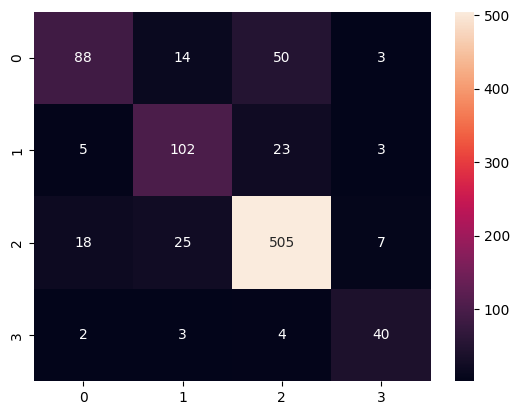

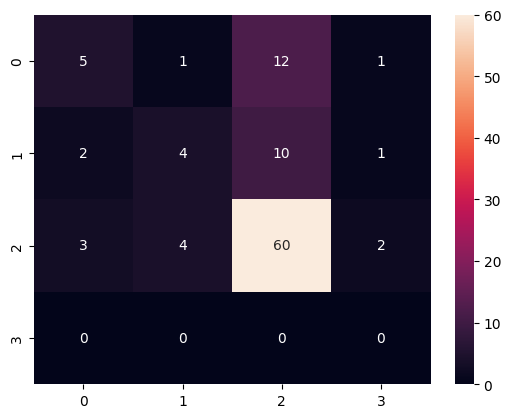

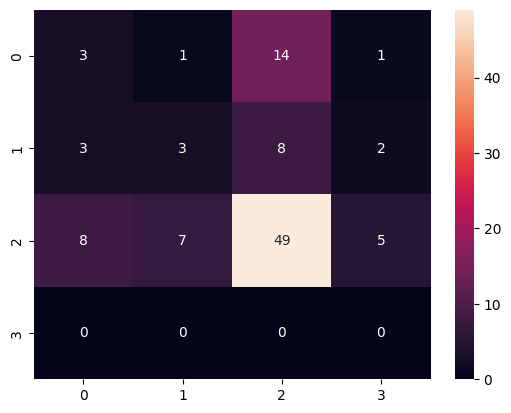

In [19]:
print("Train set metrics")

total_targets, total_preds = measure_model(model, train_loader)
display_clasification_metrics(total_preds.cpu(), total_targets.cpu())
plt.figure()

print("\nValidation set metrics")
total_targets, total_preds = measure_model(model, validation_loader)
display_clasification_metrics(total_preds.cpu(), total_targets.cpu())

plt.figure()

print("\nTest set metrics")
total_targets, total_preds = measure_model(model, test_loader)
display_clasification_metrics(total_preds.cpu(), total_targets.cpu())

In [54]:
torch.save(model.cpu().state_dict(), "models/lstm_sentiment_model_acc_84_52_61.pth")